In [1]:
import os
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset 
import torch
from datetime import datetime
import json
import re
from sklearn.utils.multiclass import unique_labels
import seaborn as sns
import matplotlib.pyplot as plt

# Setari si directoare
DATA_PATH = "big-data/discharge-notes"
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
TARGET_COLUMN = "discharge_disposition"
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
OUTPUT_DIR = f"models_v2/alexc/pubmedbert_{timestamp}"
LOG_DIR = f"logs_v2/pubmedbert_{timestamp}"
MAX_LEN = 512
NUM_ROWS = 100000
EPOCHS = 2

os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(LOG_DIR, exist_ok=True)

/bigdata/userhome/students/md5_sdbe65dc26b09e0608d639c245b5/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("=== Inceperea citirii datelor ===")
train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv")).head(NUM_ROWS)
val_df = pd.read_csv(os.path.join(DATA_PATH, "val.csv")).head(NUM_ROWS//10)
test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv")).head(NUM_ROWS//10)
print("Datele au fost citite cu succes.")

=== Inceperea citirii datelor ===
Datele au fost citite cu succes.


In [3]:
TEXT_COLUMNS = [
    'chief_complaint', 'major_surgical_procedure', 'history_of_present_illness',
    'past_medical_history', 'family_history', 'physical_exam', 'pertinent_results',
    'cxr', 'us', 'brief_hospital_course', 'medications_on_admission',
    'discharge_medications', 'discharge_condition', 'discharge_instructions'
]

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9.,;:()\- ]', '', text)
    return text.strip()

def combine_text(row):
    return " ".join([clean_text(row[col]) for col in TEXT_COLUMNS if pd.notnull(row[col])])

print("=== Inceperea preprocesarii textului ===")
for df in [train_df, val_df, test_df]:
    df['text'] = df.apply(combine_text, axis=1)
print("Preprocesarea textului a fost finalizata.")

# Creare label mapping
labels = train_df[TARGET_COLUMN].dropna().unique().tolist()
label2id = {label: i for i, label in enumerate(labels)}
id2label = {i: label for label, i in label2id.items()}

for df in [train_df, val_df, test_df]:
    df.dropna(subset=[TARGET_COLUMN], inplace=True)
    df['label'] = df[TARGET_COLUMN].map(label2id)

with open(os.path.join(OUTPUT_DIR, "label_mappings.json"), "w") as f:
    json.dump({"label2id": label2id, "id2label": id2label}, f, indent=4)

=== Inceperea preprocesarii textului ===
Preprocesarea textului a fost finalizata.


In [4]:
for df in [train_df, val_df, test_df]:
    df.dropna(subset=['label'], inplace=True)
    df['label'] = df['label'].astype('int64')
    
print("=== Crearea dataset-urilor HuggingFace ===")
train_dataset = Dataset.from_pandas(train_df[['text','label']], preserve_index=False)
val_dataset   = Dataset.from_pandas(val_df[['text','label']], preserve_index=False)
test_dataset  = Dataset.from_pandas(test_df[['text','label']], preserve_index=False)

train_dataset = train_dataset.filter(lambda x: x['label'] is not None)
val_dataset   = val_dataset.filter(lambda x: x['label'] is not None)
test_dataset  = test_dataset.filter(lambda x: x['label'] is not None)
print("Dataset-urile au fost create.")

print("=== Inceperea tokenizarii ===")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True, max_length=MAX_LEN)

train_dataset = train_dataset.map(tokenize, batched=True)
val_dataset   = val_dataset.map(tokenize, batched=True)
test_dataset  = test_dataset.map(tokenize, batched=True)

train_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
val_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
test_dataset.set_format('torch', columns=['input_ids','attention_mask','label'])
print("Tokenizarea a fost finalizata.")

=== Crearea dataset-urilor HuggingFace ===


Filter: 100%|██████████| 9457/9457 [00:00<00:00, 194698.48 examples/s]


Dataset-urile au fost create.
=== Inceperea tokenizarii ===


Map: 100%|██████████| 9457/9457 [00:04<00:00, 2303.44 examples/s]

Tokenizarea a fost finalizata.


In [5]:
print("=== Incarcare model PubMedBERT ===")
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)
print("Modelul a fost incarcat.")

def compute_metrics(pred):
    logits, labels = pred
    preds = logits.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    prec = precision_score(labels, preds, average='weighted', zero_division=0)
    rec = recall_score(labels, preds, average='weighted', zero_division=0)
    return {'accuracy': acc, 'f1': f1, 'precision': prec, 'recall': rec}

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=8,
    logging_dir=LOG_DIR,
    logging_strategy="steps",
    do_eval=True,
    eval_strategy="steps", 
    logging_steps=2000,
    eval_steps=2000,
    save_strategy="steps",
    save_steps=2000,
    save_total_limit=2, 
    learning_rate=5e-5,         
    fp16=True,
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    load_best_model_at_end=True,        
    metric_for_best_model="f1",        
    greater_is_better=True,
)

print("=== Creare Trainer ===")
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[]
)
print("Trainer-ul a fost creat.")

print("=== Inceperea antrenarii modelului ===")
trainer.train()
print("Antrenarea modelului s-a finalizat.")

=== Incarcare model PubMedBERT ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Modelul a fost incarcat.
=== Creare Trainer ===
Trainer-ul a fost creat.
=== Inceperea antrenarii modelului ===


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
2000,0.970200,0.858404,0.682483,0.676731,0.677949,0.682483
4000,0.834500,0.800479,0.699211,0.695570,0.702868,0.699211
6000,0.797100,0.771175,0.713519,0.703874,0.695829,0.713519
8000,0.723600,0.747740,0.723935,0.713531,0.704754,0.723935
10000,0.725500,0.768660,0.724250,0.710802,0.701175,0.724250


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Antrenarea modelului s-a finalizat.


=== Predict pe setul de test ===


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

=== Raport de clasificare ===
                                                                 precision    recall  f1-score   support

                                        Extended Care Facility:       0.68      0.68      0.68      1737
                                                           Home       0.80      0.88      0.84      4955
                                    Home With Service Facility:       0.57      0.52      0.55      2321
                                                        Expired       0.70      0.42      0.53       248
                                     Extended Care Facility:  )       0.00      0.00      0.00         7
                                              Home with Service       0.00      0.00      0.00        40
                                                  Extended Care       0.00      0.00      0.00        72
   Extended Care Facility:   Rehabilitation and Sub-Acute Care)       0.00      0.00      0.00         5
                        

/bigdata/userhome/students/md5_sdbe65dc26b09e0608d639c245b5/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/bigdata/userhome/students/md5_sdbe65dc26b09e0608d639c245b5/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/bigdata/userhome/students/md5_sdbe65dc26b09e0608d639c245b5/venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

Rezultatele evaluarii au fost salvate.
=== Salvarea modelului final ===
Modelul a fost salvat.
=== Afisare Confusion Matrix ===


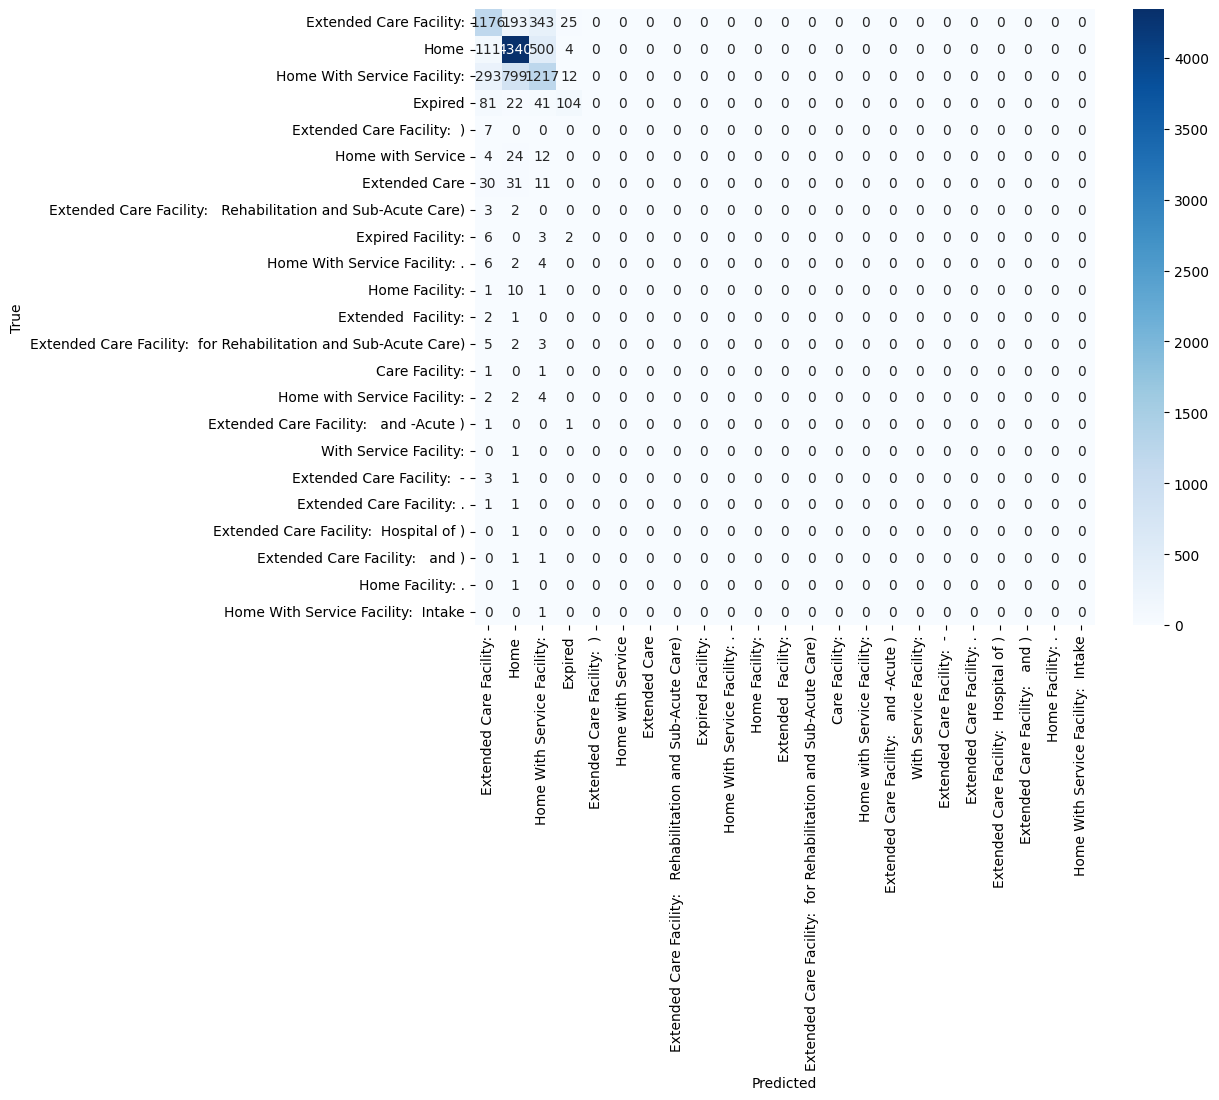

Confusion Matrix afisata.


In [6]:
print("=== Predict pe setul de test ===")
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)
labels_present = unique_labels(y_true, y_pred)

print("=== Raport de clasificare ===")
print(classification_report(
    y_true,
    y_pred,
    labels=labels_present,
    target_names=[id2label[i] for i in labels_present]
))

print("=== Evaluare finala pe setul de test ===")
results = trainer.evaluate(test_dataset)
with open(os.path.join(OUTPUT_DIR, "eval_results.json"), "w") as f:
    json.dump(results, f, indent=4)
print("Rezultatele evaluarii au fost salvate.")

print("=== Salvarea modelului final ===")
trainer.save_model(OUTPUT_DIR)
print("Modelul a fost salvat.")

print("=== Afisare Confusion Matrix ===")
cm = confusion_matrix(y_true, y_pred, labels=labels_present)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=[id2label[i] for i in labels_present],
            yticklabels=[id2label[i] for i in labels_present], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
print("Confusion Matrix afisata.")